In [1]:
import xarray as xr
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
import rasterio
from rasterio.features import geometry_mask
import rioxarray 
import cartopy.crs as ccrs
import glob
import sys
from pathlib import Path
import numpy as np
from region_details import get_region_details


### Read EFAS Regional lat/lon

In [2]:
# SORT OF USER CONFIGURATION
EFASDIR_HIST="/home/zappa/work_big/EFAS"
watershed="panaro"
tres='day'

# Name Pattern of EFAS data, * reflects different years
fname_dir=f"{EFASDIR_HIST}/output/{tres}/"
fname_dir_ws=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/"
fname_pat=f"efas_{watershed}_*.nc"
#name_pat=f"{EFASDIR_HIST}/efas_test.nc"

# variable name in EFAS file
if tres=='day':
    disname='dis24'
elif tres=='6h':
    disname='dis06'

# inner watershed grid point. Level defines the segmentation level of the watershed. Note, you might need to define different levels for different watersheds
winfo=get_region_details(watershed)
tlon=winfo['tlon']
tlat=winfo['tlat']
level=winfo['shape_file_level']
box=winfo['bounding_box']

# level='07' # general
# if watershed=="panaro":
#     tlon=10.99
#     tlat=44.65
#     level='07' # watershed specific
#     box=(44, 10.25, 45.2, 11.75)  # panaro only, lev 7
# if watershed=="reno":
#     tlon=11.3
#     tlat=44.49
#     level='07' # watershed specific
#     box=(43.9, 10.75, 44.9, 12.3)  # reno full, lev 7
#     #box=(43.9, 10.75, 44.7, 11.4)  # reno Bologna, lev 8
# elif watershed=="timis":
#     level='07'
#     tlon=22.14 # caransebes
#     tlat=45.21
#     box=(44.75, 20, 46.25, 23)  
# elif watershed=="lagen":
#     level='06'
#     tlon=10.47 # lillehammer
#     tlat=61.11 # 
#     box=(60, 7, 62.5, 12) 
# elif watershed=="aragon":
#     level='07'
#     tlon=-1.1
#     tlat=42.6
#     box=(42, -2.5, 43.2, -0.25)
# else:
#     print("Unknown watershed")
#     exit(1) 

wspoint = Point(tlon, tlat)

writeout=True
force=True


Unknown watershed


### Read discharge data

In [3]:
ds = xr.open_mfdataset(f"{fname_dir}/{fname_pat}", combine='by_coords')

### Read watershed shape files

In [4]:
shape_dir="/work_big/users/zappa/TRANSLATE/HydroBasins/hybas_lake_eu_lev01-12_v1c/"
shapef_path = os.path.join(shape_dir,f"hybas_lake_eu_lev{level}_v1c.shp")
shape_gdf = gpd.read_file(shapef_path)

### Select watershed of interest

In [5]:
# grid point of river point to be anlaysed
contains_point = shape_gdf['geometry'].contains(wspoint)

# extract entry of shapefile that contains the point
shape_basin_gdf = shape_gdf[contains_point]

Mask the data

In [6]:
# extract geometry of the basin
basin_geometry = shape_basin_gdf['geometry'].values

# changes to the dataset needed to use the geometry_mask function
if watershed=="aragon":
    ds['lon']=ds['lon']-360

ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True)

# Create a mask where True values represent points inside the shapefile
mask = geometry_mask([geom for geom in basin_geometry ],
                     out_shape=(ds.sizes['lat'], ds.sizes['lon']),
                     transform=ds.rio.transform(),
                     invert=True)


# convert mask to xarray dataset
mask_ds = xr.DataArray(mask, dims=('lat', 'lon'), coords={'lat': ds.lat, 'lon': ds.lon})

# set mask variable name euivalent to the discharge variable
mask_ds.name=disname

# change data type to float32
mask_ds = mask_ds.astype('float32')




In [7]:

# Apply the mask to the dataset and plot the results
ds_masked = ds[disname].where(mask)


Plot a single timestep to visualize basin 

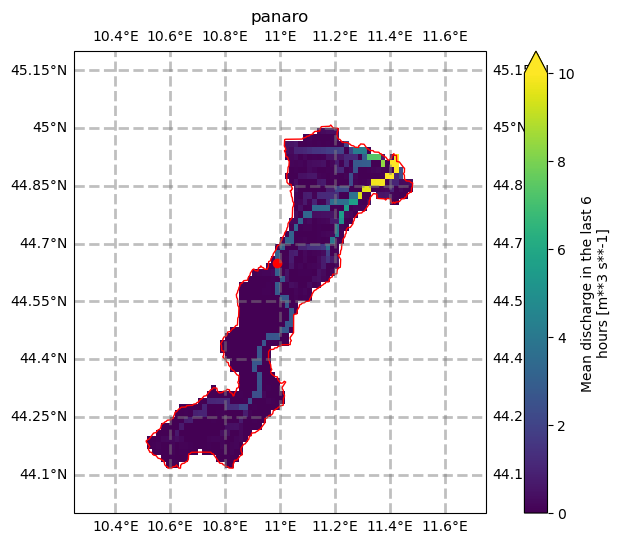

In [8]:
# select a timestep from the masked file
var=ds_masked.isel(time=0)

# Create a figure and axes with a geographic projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=10)

# plot basin geometry
shape_basin_gdf.plot(ax=ax, facecolor='none', edgecolor='red')

# subset the domain plus/minus 5 degree to the point
lonmin=box[1]
lonmax=box[3]
latmin=box[0]
latmax=box[2]
ax.set_extent([lonmin, lonmax, latmin, latmax])

# add point corresponding at latitude tlat and longitude tlon
ax.plot(tlon, tlat, 'ro', transform=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# add lat lon labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Show the plot
plt.title(f"{watershed}")
plt.show()

# Basin specific corrections

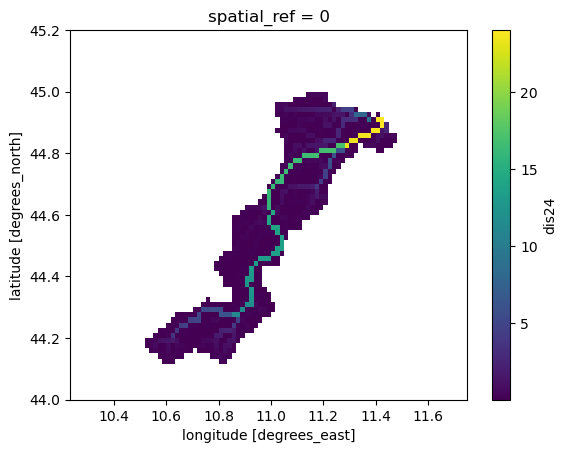

In [9]:

if watershed=="panaro":
    # remove a Po' river grid point 
    ds_masked=ds_masked.where(ds_masked.mean(dim='time')<100)
    mask_ds=mask_ds.where(ds_masked.mean(dim='time')<100)
elif watershed=="timis":
    # remove a Danube river grid point 
    ds_masked=ds_masked.where(ds_masked.mean(dim='time')<200)
    mask_ds=mask_ds.where(ds_masked.mean(dim='time')<200)
elif watershed=="aragon":   
    mask_ds['lon']=mask_ds['lon']+360

ds_masked.mean(dim='time').plot()
plt.show()


In [12]:
# commented since really slow
if writeout==True:
    outfile=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/efas_{watershed}_masked.nc"
    ds_masked.to_netcdf(outfile)

### Apply Mask using CDO

In [ ]:
writeout=False
if writeout:
    # write it to netcdf if maskfile does not exists or force is set
    maskfile=f"{fname_dir_ws}/{watershed}_mask.nc"
    
    if Path(maskfile).is_file() and force:
        os.remove(maskfile)
        mask_ds.to_netcdf(maskfile)
    elif not Path(maskfile).is_file():
        mask_ds.to_netcdf(maskfile)

    # list file corresponding to fname_pat
    files_input = list(Path(fname_dir).rglob(fname_pat))
    print(files_input)

    # Loop over the files
    for file in files_input:
        # extract the file name
        file_name = os.path.basename(file)

        # create the output file name
        file_out = f"{fname_dir_ws}{file_name}"
        print(file_out)

        # apply the mask
        os.system(f"cdo -s div -selvar,{disname} {file} -selvar,{disname} {maskfile} {file_out}")
        print(f"File {file} processed")

    print("All files processed")    

[PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_2015.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_1997.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_1996.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_2003.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_1994.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_2019.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_1998.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_2018.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_1995.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_2009.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_1993.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_1999.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_2012.nc'), PosixPath('/home/zappa/work_big/EFAS/output/day/efas_aragon_2013.nc'), Posix

### Save output to nc